In [1]:
# Data visualization
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd
import numpy as np
import re

# Vector representations and embeddings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Modeling - Logistic, XGBOOST, SVM
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [2]:
import sys
sys.path.append(f'../../src/python')

from balance_split_data import create_label, retain_section, balance_unique_id, \
create_balanced_excluded, create_train_test_excluded, group_by_case, create_feature_label

from grid_search import gridsearch, fit_best_model_train, evaluate, fit_best_model_test, get_feature_importance_cv

from ml_model import train_model_cross_val, train_model_test, \
get_feature_importance, get_feature_importance10

### Load data

In [3]:
df = pd.read_json(r"../../data/processed/pre-processed_merged_2023_04_04.json")

In [4]:
# Define a regular expression pattern to match the unwanted words
remove_words = ['dg comp merger registry', 'belgië', 'tel fax mail', 'tel', 'fax', 'comp merger registry',
                'ec europa eu', 'belgië fax', 'comp merger registry', 'tel', 'tel fax', 'fax mail', 'registry fax']
remove_pattern = re.compile(r'\b(' + '|'.join(remove_words) + r')\b', flags=re.IGNORECASE)
df['text_clean'] = df['text_clean'].replace(remove_pattern, '', regex=True)

#### Loop creation of train and test sets by section

In [5]:
label_name = "phase2"
section_dict={0:'Parties & Operation', 1:'Concentration & Dimension', 
              2:'Market Definition', 3:'Competitive Assessment'}
random_seed=42
random_state=42

In [6]:
# Loop by section and p2
for section_key in section_dict.keys():
    df1 = create_label(df, label_name)
    df1 = retain_section(df1, section=section_dict[section_key])
    print(df1['section_fin'].value_counts())
    df_unique = balance_unique_id(df1)
    df_balanced_unique, df_balanced, df_excluded = create_balanced_excluded(df_unique, df1, random_seed=random_seed)
    df_train, df_test, df_test1 = create_train_test_excluded(df_balanced, df_balanced_unique, df_excluded, random_state=random_state)
    globals()[f"df_train_grouped_{section_key}"], globals()[f"df_test_grouped_{section_key}"], \
    globals()[f"df_test1_grouped_{section_key}"], globals()[f"df_excluded_grouped_{section_key}"] = group_by_case(df_train, df_test, df_test1, df_excluded)

    globals()[f"X_train_{section_key}"], globals()[f"y_train_{section_key}"], globals()[f"X_test_{section_key}"], globals()[f"y_test_{section_key}"], \
    globals()[f"X_test1_{section_key}"], globals()[f"y_test1_{section_key}"], globals()[f"X_test2_{section_key}"], globals()[f"y_test2_{section_key}"] = create_feature_label(globals()[f"df_train_grouped_{section_key}"],
                                                                                                                                                            globals()[f"df_test_grouped_{section_key}"],
                                                                                                                                                            globals()[f"df_test1_grouped_{section_key}"],
                                                                                                                                                            globals()[f"df_excluded_grouped_{section_key}"])

Parties & Operation    1442
Name: section_fin, dtype: int64
Total decisions: 1441
0    1376
1      65
Name: label, dtype: int64
Balancing...
Total decisions: 130
Labels distribution: 
 1    65
0    65
Name: 0, dtype: int64
Training set shape: (104,) (104,)
Test set shape: (26,) (26,)
Creating df_train 1: 52 0: 52
Creating df_test1 1: 13 0: 13
Creating df_test concatenated with df_excluded with len: 1311
Creating df_test 1: 13 0: 1324
Grouping df_train by case_num 1: 52 0: 52
Grouping df_test by case_num 1: 13 0: 1324
Grouping df_test1 by case_num 1: 13 0: 13
Grouping df_excluded by case_num with len: 1311
Concentration & Dimension    1538
Name: section_fin, dtype: int64
Total decisions: 1538
0    1467
1      71
Name: label, dtype: int64
Balancing...
Total decisions: 142
Labels distribution: 
 0    71
1    71
Name: 0, dtype: int64
Training set shape: (114,) (114,)
Test set shape: (29,) (29,)
Creating df_train 1: 57 0: 57
Creating df_test1 1: 14 0: 15
Creating df_test concatenated with d

### Model training (with 10-fold CV) using best parameters from GridSearch

In [8]:
# lowercase, remove stopwords
vec = ('wordvec', TfidfVectorizer(analyzer = 'word', max_features=5000, lowercase=True, stop_words='english', \
                                  ngram_range = (2,2), binary = True, max_df = 0.025, norm = 'l1', use_idf = False))
c = 1
model = LinearSVC(C=c)

In [9]:
df_metrics = pd.DataFrame(columns = ['set', 'section', 'tn', 'fp', 'fn', 'tp', 'recall', 'precision', 'f_score', 'fpr', 'accuracy', 'roc_auc'])

In [10]:
for section_key in section_dict.keys():
    # balanced train
    globals()[f"pipeline_train_{section_key}"], globals()[f"trained_model_{section_key}"], globals()[f"y_predict_train_{section_key}"] = train_model_cross_val(globals()[f"X_train_{section_key}"], globals()[f"y_train_{section_key}"], vec=vec, model=model, cv=10)
    globals()[f"df_features_train_{section_key}"], _, _ = get_feature_importance(globals()[f"trained_model_{section_key}"], globals()[f"pipeline_train_{section_key}"])
    metrics_train=evaluate(globals()[f"y_train_{section_key}"],globals()[f"y_predict_train_{section_key}"])
    set = "balanced train"
    section = section_dict[section_key]
    row_train = pd.DataFrame({'set':set, 'section':section, 'tn':metrics_train[0], 'fp':metrics_train[1], 'fn':metrics_train[2], 'tp':metrics_train[3], \
                        'recall':metrics_train[4], 'precision':metrics_train[5], 'f_score':metrics_train[6], \
                        'fpr':metrics_train[7], 'accuracy':metrics_train[8], 'roc_auc':metrics_train[9]}, index=[0])
    
    # balanced test
    _, globals()[f"y_predict_test1_{section_key}"] = train_model_test(globals()[f"X_train_{section_key}"], globals()[f"y_train_{section_key}"], \
                                                     globals()[f"X_test1_{section_key}"], globals()[f"y_test1_{section_key}"], model=model, vec=vec)
    metrics_test1=evaluate(globals()[f"y_test1_{section_key}"],globals()[f"y_predict_test1_{section_key}"])
    set = "balanced test"
    row_test1 = pd.DataFrame({'set':set, 'section':section, 'tn':metrics_test1[0], 'fp':metrics_test1[1], 'fn':metrics_test1[2], 'tp':metrics_test1[3], \
                        'recall':metrics_test1[4], 'precision':metrics_test1[5], 'f_score':metrics_test1[6], \
                        'fpr':metrics_test1[7], 'accuracy':metrics_test1[8], 'roc_auc':metrics_test1[9]}, index=[0])
    
    # imbalanced test
    _, globals()[f"y_predict_test_{section_key}"] = train_model_test(globals()[f"X_train_{section_key}"], globals()[f"y_train_{section_key}"], \
                                                     globals()[f"X_test_{section_key}"], globals()[f"y_test_{section_key}"], model=model, vec=vec)
    metrics_test=evaluate(globals()[f"y_test_{section_key}"],globals()[f"y_predict_test_{section_key}"])
    set = "imbalanced test"
    row_test = pd.DataFrame({'set':set, 'section':section, 'tn':metrics_test[0], 'fp':metrics_test[1], 'fn':metrics_test[2], 'tp':metrics_test[3], \
                        'recall':metrics_test[4], 'precision':metrics_test[5], 'f_score':metrics_test[6], \
                        'fpr':metrics_test[7], 'accuracy':metrics_test[8], 'roc_auc':metrics_test[9]}, index=[0])

    df_metrics = pd.concat([df_metrics.loc[:], row_train, row_test1, row_test]).reset_index(drop=True)

df_metrics['n'] = df_metrics['tn'] + df_metrics['fp'] + df_metrics['fn'] + df_metrics['tp']

***10-fold cross-validation***
Accuracy: 0.6057692307692307

Classification report:
               precision    recall  f1-score   support

           0       0.60      0.63      0.62        52
           1       0.61      0.58      0.59        52

    accuracy                           0.61       104
   macro avg       0.61      0.61      0.61       104
weighted avg       0.61      0.61      0.61       104


CR: (0.6061224489795918, 0.6057692307692307, 0.605440917923568, None)

Confusion matrix:
 [[33 19]
 [22 30]] 

_______________________


 Accuracy: 60.577 
 Precision: 0.612 
 Recall: 0.577 
 F1: 0.594 
 FPR: 0.365 
 ROC_AUC: 0.606
Accuracy: 0.6057692307692307

Classification report:
               precision    recall  f1-score   support

           0       0.60      0.63      0.62        52
           1       0.61      0.58      0.59        52

    accuracy                           0.61       104
   macro avg       0.61      0.61      0.61       104
weighted avg       0.61      

In [11]:
df_metrics

,set,section,tn,fp,fn,tp,recall,precision,f_score,fpr,accuracy,roc_auc,n
0,balanced train,Parties & Operation,33,19,22,30,0.576923,0.612245,0.594059,0.365385,60.576923,0.605769,104
1,balanced test,Parties & Operation,7,6,2,11,0.846154,0.647059,0.733333,0.461538,69.230769,0.692308,26
2,imbalanced test,Parties & Operation,700,624,2,11,0.846154,0.017323,0.033951,0.471299,53.178758,0.687427,1337
3,balanced train,Concentration & Dimension,22,35,9,48,0.842105,0.578313,0.685714,0.614035,61.403509,0.614035,114
4,balanced test,Concentration & Dimension,5,10,3,11,0.785714,0.523810,0.628571,0.666667,55.172414,0.559524,29
5,imbalanced test,Concentration & Dimension,435,975,3,11,0.785714,0.011156,0.022000,0.691489,31.320225,0.547112,1424
6,balanced train,Market Definition,15,52,4,60,0.937500,0.535714,0.681818,0.776119,57.251908,0.580690,131
7,balanced test,Market Definition,11,5,2,16,0.888889,0.761905,0.820513,0.312500,79.411765,0.788194,34
8,imbalanced test,Market Definition,496,408,2,16,0.888889,0.037736,0.072398,0.451327,55.531453,0.718781,922
9,balanced train,Competitive Assessment,6,54,2,58,0.966667,0.517857,0.674419,0.900000,53.333333,0.533333,120


In [12]:
df_metrics.to_excel('../../output/tables/svm_metrics_section_p2.xlsx', index=True)

### Feature importance

Get features for label = 1 and label = 0

In [13]:
for section_key in section_dict.keys():
    globals()[f"df_features_train1_{section_key}"], globals()[f"df_features_train0_{section_key}"] = get_feature_importance10(globals()[f"df_features_train_{section_key}"])

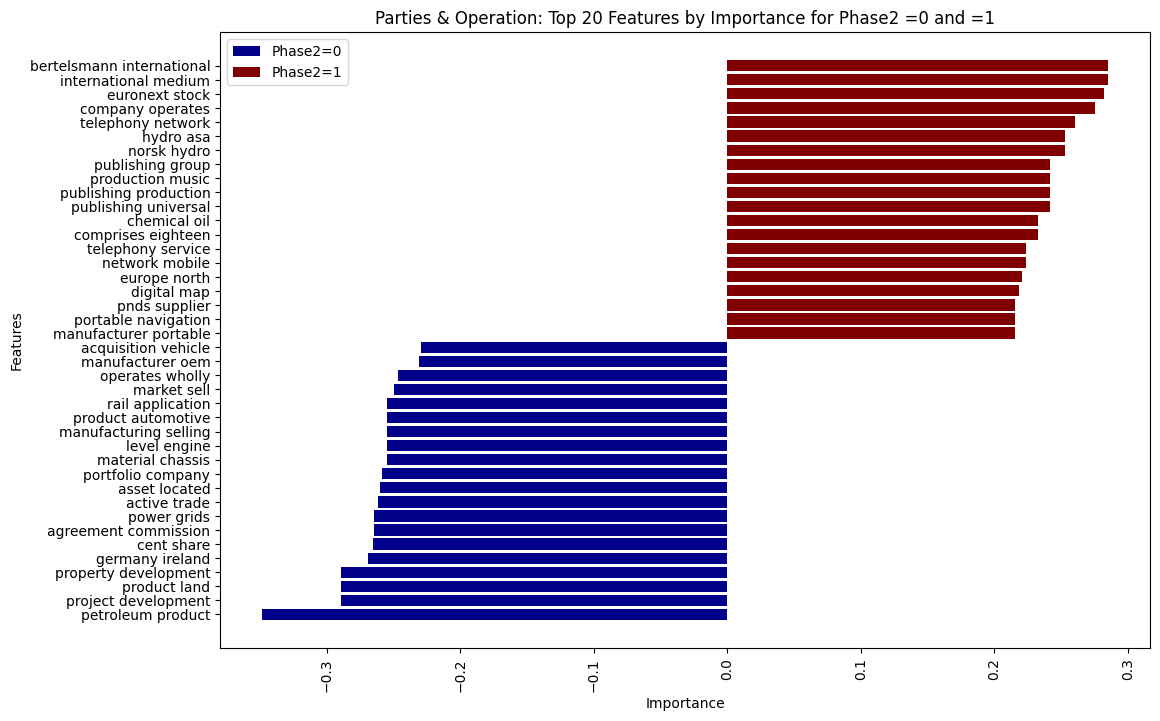

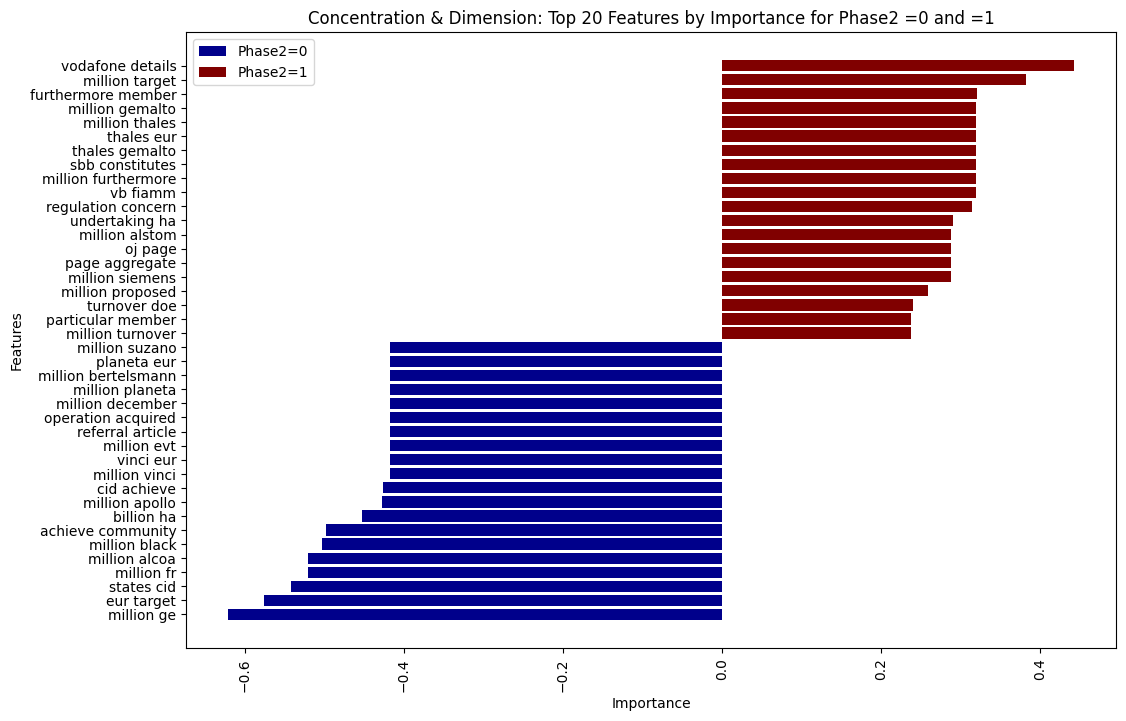

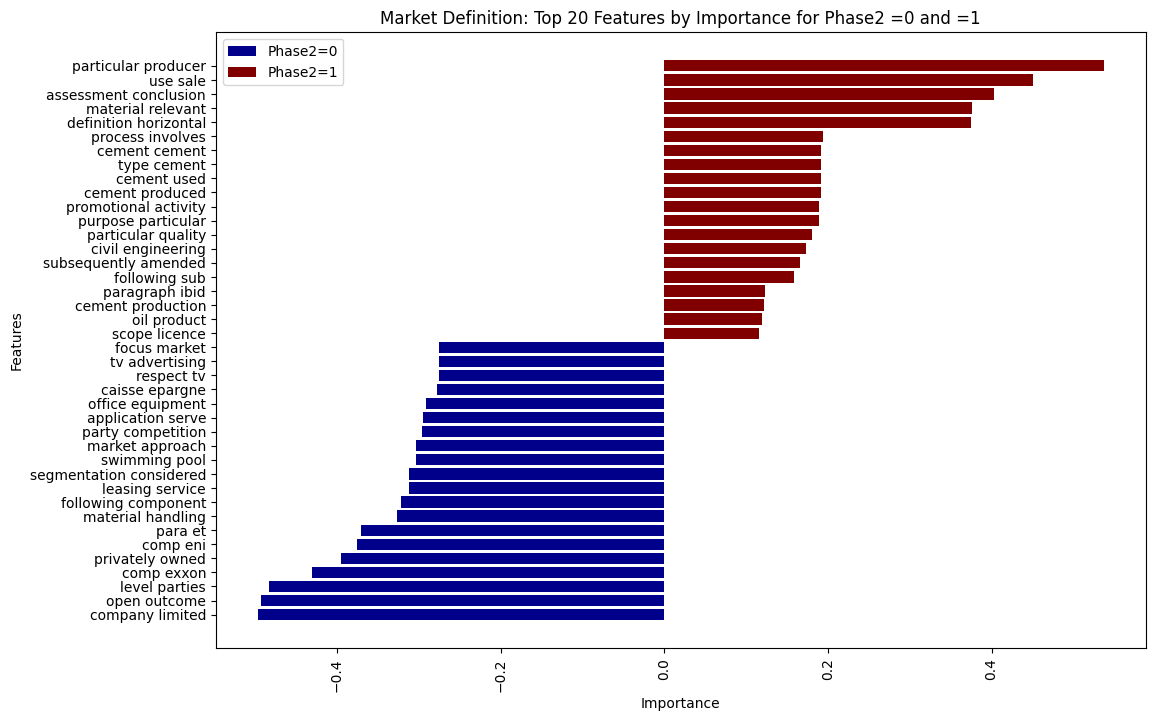

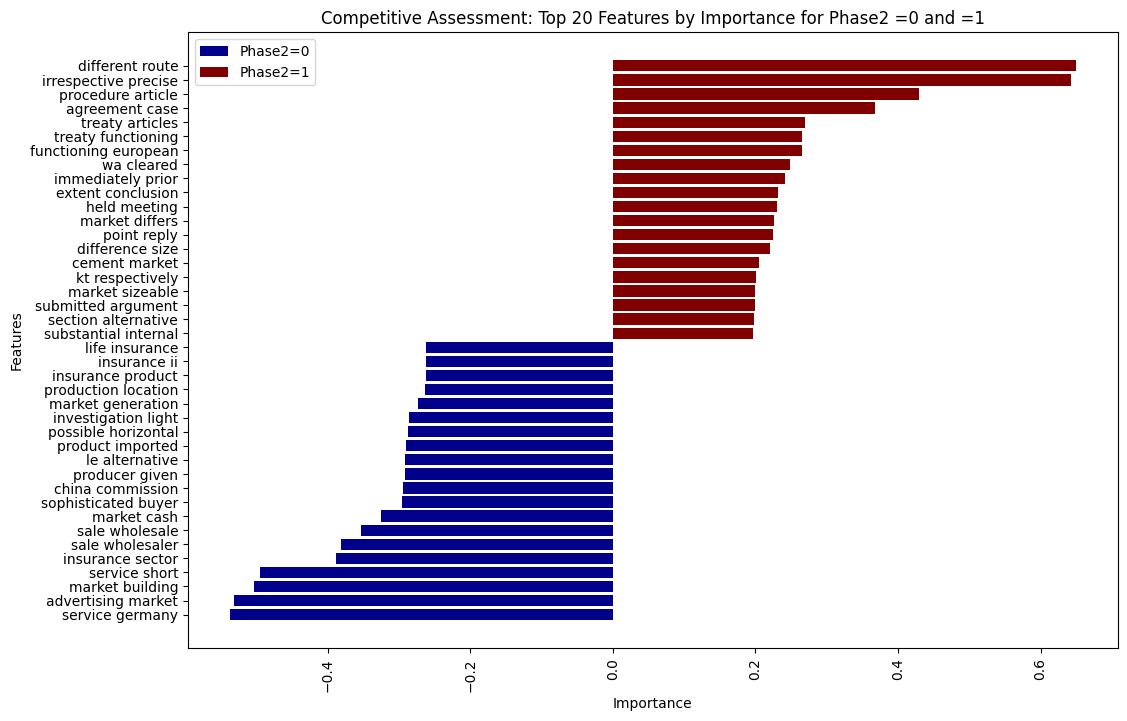

In [14]:
for section_key in section_dict.keys():
    # Sort the features by absolute importance for label=1
    globals()[f"df_features_train1_{section_key}"] = globals()[f"df_features_train1_{section_key}"].sort_values(by='abs_importance', ascending=False)
    globals()[f"df_features_train1_top10_{section_key}"] = globals()[f"df_features_train1_{section_key}"].nlargest(20, 'abs_importance')
    globals()[f"df_features_train1_top10_{section_key}"] = globals()[f"df_features_train1_top10_{section_key}"].sort_values('importance', ascending=True)

    # Sort the features by absolute importance for label=0
    globals()[f"df_features_train0_{section_key}"] = globals()[f"df_features_train0_{section_key}"].sort_values(by='abs_importance', ascending=False)
    globals()[f"df_features_train0_top10_{section_key}"] = globals()[f"df_features_train0_{section_key}"].nlargest(20, 'abs_importance')

    # Create a combined bar chart
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.barh(globals()[f"df_features_train0_top10_{section_key}"]['feature'], globals()[f"df_features_train0_top10_{section_key}"]['importance'], color='darkblue', label='Phase2=0')
    ax.barh(globals()[f"df_features_train1_top10_{section_key}"]['feature'], globals()[f"df_features_train1_top10_{section_key}"]['importance'], color='maroon', label='Phase2=1')
    ax.set_xlabel('Importance')
    ax.set_ylabel('Features')
    ax.set_title(str(section_dict[section_key])+ ': Top 20 Features by Importance for Phase2 =0 and =1')
    ax.legend()
    plt.xticks(rotation=90)
    #plt.show()

    plt.savefig('../../output/figures/svm_p2_section_' + str(section_key) + '.png', bbox_inches='tight')

In [15]:
for section_key in section_dict.keys():
    globals()[f"df_features_train_{section_key}"].to_excel('../../output/tables/features_svm_p2_section_' + str(section_key) + '.xlsx', index=True)